# Language Classification with Naive Bayes in Python

## Recommended Prerequisites for Successful Completion
* Intermediate level understanding of Python 3+ (e.g. list and dictionary comprehension)
* Basics of machine learning (e.g. the distinction between training and validation data)
* Mathematical probability (e.g. understanding Bayes' Theorem at a basic level)


## Project Outline
[**Introduction**](#intro)

[**Task 1**](#task1): Exploratory Data Analysis + Visualization

[**Task 2**](#task2): Data Cleaning and Preprocessing

[**Task 3**](#task3): Naive Bayes Model Introduction and Training

[**Task 4**](#task4): Highlighting Problems with Basic Model and Simple Fixes

[**Task 5**](#task5): Advanced Approach to Further Improve Performance

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

<a id='intro'></a>
# Introduction

In [3]:
model = joblib.load('Data/Models/final_model.joblib')
vectorizer = joblib.load('Data/Vectorizers/final_model.joblib')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## [Slovak Wikipedia Entry](https://sk.wikipedia.org/wiki/Jazveč%C3%ADk)
Mnohí ľudia, ktorí vidia na ulici jazvečíka s podlhovastým telom vôbec nevedia o tom, že tento malý štvornohý a veľmi obľúbený spoločník je pri dobrom výcviku obratným, vynikajúcim a spoľahlivým poľovným psom. Ako poľovný pes je mnohostranne využiteľný, okrem iného ako durič na brlohárenie. Králičí jazvečík sa dokáže obratne pohybovať v králičej nore. S inými psami a deťmi si nie vždy rozumie.

## [Czech Wikipedia Entry](https://cs.wikipedia.org/wiki/Jezevč%C3%ADk)
Úplně první zmínky o psech podobných dnešním jezevčíkům nacházíme až ve Starém Egyptě, kde jsou vyobrazeni na soškách a rytinách krátkonozí psi s dlouhým hřbetem a krátkou srstí. Jednalo se ale o neustálený typ bez ustáleného jména. Další zmínky o jezevčících nacházíme až ve 14 - 15. století. Jedná se o psa, který se nejvíce podobá dnešnímu typu hladkosrstého standardního jezevčíka.


## [English Wikipedia Entry](https://en.wikipedia.org/wiki/Dachshund)
While classified in the hound group or scent hound group in the United States and Great Britain, the breed has its own group in the countries which belong to the Fédération Cynologique Internationale (World Canine Federation). Many dachshunds, especially the wire-haired subtype, may exhibit behavior and appearance that are similar to that of the terrier group of dogs.

In [4]:
text = 'okrem iného ako durič na brlohárenie'
text = preprocess_function(text)
text = [split_into_subwords_function(text)]
text_vectorized = vectorizer.transform(text)

model.predict(text_vectorized)

array(['sk'], dtype='<U2')

There are some shortcomings with this model. Ex: Hello world is preedicted as cs (Czech)

<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [5]:
def open_file(filename):
    with open(filename, encoding='utf8') as f:
        data = f.readlines()
    return data

In [6]:
#The best data structure to store different languages is using a dictionary.
data_raw = dict()
data_raw['sk'] = open_file('Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('Data/Sentences/train_sentences.en')

In [7]:
#list of strings
#We might have to deal with \n character at the end of each line
data_raw['en']

['I can understand your approach a little bit.\n',
 'Membership of Parliament: see Minutes\n',
 'The establishment of a joint EU resettlement programme (\n',
 'Decentralisation is very important for sustainable energy.\n',
 'A majority rejected these solutions and wishes to stay in Bosnia.\n',
 '(RO) At the start of the year, the unemployment rate reached 10%, while the deficit has grown in numerous Member States.\n',
 'We are, as honourable Members know, supporting projects worldwide in the fight against racism, xenophobia or discrimination on any ground.\n',
 'Agenda for next sitting: see Minutes\n',
 'In addition, communities should be supported both financially and by specific solutions on the regional level, in order to improve the level of communal services.\n',
 'This includes all commercial aspects of exploitation as well as the legal, contractual and financing structures of the different exploitation models that will ensure that a stable governance model is put into place.\n',

In [8]:
def show_statistics(data):
    for language, sentences in data.items():
        #wordd_list is the list of words (converted sentences into a list of words)
        word_list = ' '.join(sentences).split()
        
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        #let's say 7 words in each sentence
        #break down 7 words and join them together with a whitespace
        sample_extract = ' '.join(sentences[0].split()[0:7]) 
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [9]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...



You might be thinking since 'cs' has less number of sentences, it might create a class imbalance problem in modeling. Maybe biased towards classes having more data. Another difficult thing is that 'cs' also has less number of total words and less number of unique words. 

We might want to deal with uppercase letters & punctuation in some way. In complex language problems, it is interesting to visualize rank vs frequency of words sorted by highest frequency. 

Zipf's law: Frequency of a word is inversely proportional to its rank. Most frequently occurrring word will occur twice as much as the second most frequently occurring word and onwards. There is a linear relationship between the frequency & rank in the log-space.

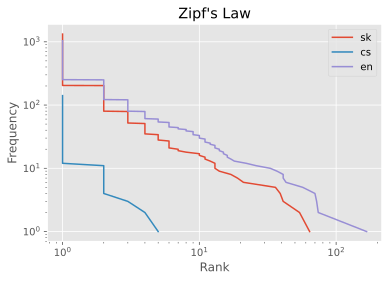

In [10]:
# We can't expect the relationship to be perfect as we don't have a large amount of data. 
# 'sk' & 'en' show a linear relationship in the middle but 'cs' doesn't show so
# This can be due to low vocabulary size which demonstrates high variance. We need to consider this in our modeling step if
# we don't get the expected performance
do_law_of_zipf(data_raw)

<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

Some relatively standard proceedures in NLP are punctuation removal, converting numerals into words, converting all characters into lowercase, stemming & lemmatizing words (converting to root form), POS tagging, Named entity recognition & general cleaning of the data like removing HTML tags or removing trailing whitespaces

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
string.digits

'0123456789'

In [13]:
str.translate?

In [14]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
    preprocessed_text = text.lower().replace('-', ' ')
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    preprocessed_text = preprocessed_text.translate(translation_table) 
    return preprocessed_text

In [15]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [16]:
print('Raw-text Statistics:')
print(show_statistics(data_raw))
print('\n Preprocessed-text Statistics:')
print(show_statistics(data_preprocessed))

Raw-text Statistics:
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...

None

 Preprocessed-text Statistics:
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujeme že jejím cílem je šetřit penězi...

Language: en
--

<a id='task3'></a>
# Task 3: The Naive Bayes Model

Bayes' Theorem assumes independence between features. It is well known for multi-class classification problems. 

In text classification, it has higher success rate than other classification algorithms.

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `My name is Vishnu` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {My name is Vishnu})=\frac{P(\text {My name is Vishnu} | \text {sk}) \times P(\text {sk})}{P(\text {My name is Vishnu})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {My name is Vishnu})=\frac{P(\text {My name is Vishnu} | \text {cs}) \times P(\text {cs})}{P(\text {My name is Vishnu})}
\end{equation}

\begin{equation}
P(\text {en} | \text {My name is Vishnu})=\frac{P(\text {My name is Vishnu} | \text {en}) \times P(\text {en})}{P(\text {My name is Vishnu})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {My name is Vishnu} | \text {en}) = P(\text {My} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Vishnu} | \text {en})
\end{equation}

Naive Bayes is a Bag of Words model which means the ordering of words doesn't matter. So, My is name Vishnu will have the same probability as that of My name is Vishnu.

Let's say that we haven't come across the word 'Vishnu' until now, then \begin{equation} P(\text {Vishnu} | \text {en}) \end{equation} will be zero.

This is not a fair thing. Just because we haven't seen the word doesn't mean that it doesn't exist. We want to give probability mass for the words that don't exist. This is called smoothing.

Laplace smoothing is one of the ways of doing this which is add 1 to the numerator & vocabulary size to the denominator.
For a small sample size, there is more smoothing, which we need. 

For example, 0.99 * 0.99 * 0.99 * 0: should be high, but we get a result of zero which is incorrect.

The Naive Bayes' classifier uses Gaussian distribution for \begin{equation} P(\text {f} | \text {c}) \end{equation} while Multinomial Naive Bayes' uses a multinomial distribution which works well for word counts. 

Multinomial distribution gives the probability of when there are more than 2 outcomes. Binomial distribution is a special case of multinomial distribution when there are just 2 outcomes. 

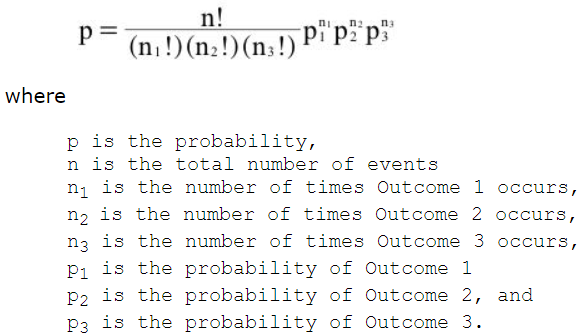

In [17]:
from IPython.display import Image
Image(filename='Multinomial Distribution.PNG')

## Vectorizing Training Data

|Sentence   	||   My   	| is 	| I 	| love 	| name 	| it 	| Vishnu 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| My name is Vishnu  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [18]:
# List of inputs & outputs
sentences_train, y_train = [], []
for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [19]:
vectorizer = CountVectorizer()

In [20]:
X_train = vectorizer.fit_transform(sentences_train)

In [21]:
X_train
#sparse: lot of zeros: which is expected

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [22]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Vectorizing Validation Data and Evaluating Model

In [23]:
data_val = dict()
data_val['sk'] = open_file('Data/Sentences/val_sentences.sk')
data_val['cs'] = open_file('Data/Sentences/val_sentences.cs')
data_val['en'] = open_file('Data/Sentences/val_sentences.en')

data_val_preprocessed = {k: [preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [24]:
sentences_val, y_val = [], []

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [25]:
X_val = vectorizer.transform(sentences_val)

In [26]:
predictions = naive_classifier.predict(X_val)

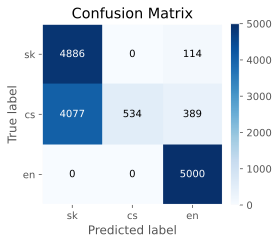

In [27]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

Because Czech & Slovak are very similar, a lot of Czech is being predicted as slovak. We don't have class imbalance in validation dataset. If you sum entries row-wise, sum is always 5000.

F1 score is important when there is class imbalance in the data. It is robust.

In [28]:
f1_score(y_val, predictions, average='weighted')

0.6149824401040264

<a id='task4'></a>
# Task 4: Simple Adjustments and Highlighting Model Shortcomings

Earlier, fit_prior = True, which means it would be biased towards Slovak & english just beacuse of more data. Negate that by setting it to False which means model will consider uniform distribution for all classes. Play around with alpha, I found 0.0001 to work the best.

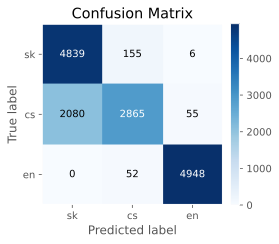

In [31]:
naive_classifier = MultinomialNB(alpha=0.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

plot_confusion_matrix(y_val, predictions, ['sk','cs', 'en'])

It's much better, less misclassification of Czech as Slovak. Now some English is being misclassified as Czech which is no longer perfect because we have set fit_prior to False 

In [32]:
#huge improvement
f1_score(y_val, predictions, average='weighted') #average of f1-scores of 3 languages

0.8368507601649364

<a id='task5'></a>
# Task 5: Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

#### Read more about subwords here: https://arxiv.org/abs/1508.07909. It is the original introduction to using subwords in NLP tasks. Classically been used for neural machine translation. (Translate words you may not have seen in training data).

Use subwords to translate small pieces of a big word in hopes of achieving better performance. It has been shown to work pretty well.

In [34]:
# create vocabulary: frequency of words
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [35]:
vocab = get_vocab(sentences_train)

In [56]:
sentences_train

['pán de grandes pascual jasne vysvetlil aká je pridaná hodnota definície terorizmu vyjadrením že definícia ktorú sme používali predtým bola dôležitejšia ale aj tým že trval na zozname priestupkov ',
 'keby sme sa nepokúsili o nemožné ako by sme mohli dosiahnuť zmenu ',
 'oznámil že budúci týždeň sa zúčastní schôdze výboru pre zahraničné veci ',
 'niekedy by sa mohlo zdať že ide o hru alebo pokrytectvo ',
 'jej účelom je tiež identifikovať akékoľvek slabé miesta v systéme a právne nedostatky súdnej spolupráce v trestných veciach aby sa európskym zákonodarcom poskytli všetky informácie potrebné na správne politické a regulačné hodnotenie ',
 'na dosiahnutie tohto cieľa je mimoriadne dôležité aby členské štáty zaviedli prijaté opatrenia a úzko spolupracovali ',
 'fr pani predsedajúca pán predseda barroso nám stanovil náročný cieľ v oblasti výroby obnoviteľnej energie s cieľom znížiť emisie skleníkových plynov bez toho aby sa brzdili naše vyhliadky na rast ',
 'táto požiadavka však nie je

In [33]:
import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

In [58]:
pairs = get_stats(vocab)
pairs

defaultdict(int,
            {('p', 'á'): 13,
             ('á', 'n'): 19,
             ('g', 'r'): 14,
             ('r', 'and'): 1,
             ('and', 'e'): 1,
             ('e', 's'): 16,
             ('p', 'as'): 2,
             ('as', 'c'): 1,
             ('c', 'u'): 13,
             ('u', 'al'): 10,
             ('j', 'as'): 3,
             ('as', 'ne'): 3,
             ('vy', 's'): 2,
             ('s', 've'): 4,
             ('ve', 't'): 4,
             ('t', 'li'): 4,
             ('li', 'l'): 2,
             ('ak', 'á'): 1,
             ('pr', 'i'): 21,
             ('i', 'd'): 19,
             ('d', 'an'): 5,
             ('an', 'á'): 6,
             ('ho', 'd'): 19,
             ('d', 'not'): 5,
             ('not', 'a'): 1,
             ('de', 'f'): 3,
             ('f', 'in'): 11,
             ('in', 'í'): 2,
             ('í', 'c'): 7,
             ('c', 'ie'): 16,
             ('te', 'ro'): 1,
             ('ro', 'ri'): 1,
             ('ri', 'z'): 3,
             ('

In [66]:
best = max(pairs, key=pairs.get)
best

('o', 'b')

In [67]:
pairs[('o', 'b')]

27

In [68]:
def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [69]:
merge_vocab(best, vocab)

{'p á n': 8,
 'de': 5,
 'g r and e s': 1,
 'p as c u al': 1,
 'j as ne': 1,
 'vy s ve t li l': 1,
 'ak á': 1,
 'je': 31,
 'pr i d an á': 1,
 'ho d not a': 1,
 'de f in í c ie': 1,
 'te ro ri z mu': 1,
 'vy j ad re n í m': 1,
 'že': 43,
 'de f in í c ia': 1,
 'ktor ú': 2,
 's me': 11,
 'po u ž í v al i': 1,
 'pre d t ý m': 1,
 'bo la': 3,
 'd ô le ž it e j š ia': 1,
 'al e': 6,
 'aj': 6,
 't ý m': 4,
 't r v al': 1,
 'na': 41,
 'z o z na me': 1,
 'pr ie st u p k ov': 1,
 'ke by': 2,
 'sa': 40,
 'ne po k ú si li': 1,
 'o': 19,
 'ne mo ž né': 1,
 'ak o': 10,
 'by': 29,
 'mo h li': 5,
 'do s ia h n u ť': 2,
 'z m en u': 1,
 'o z n á m il': 1,
 'bu d ú ci': 1,
 't ý ž de ň': 2,
 'z ú č a st n í': 1,
 's ch ô d z e': 1,
 'vý b or u': 1,
 'pre': 10,
 'z a h r an i č né': 1,
 've ci': 1,
 'n ie k ed y': 1,
 'mo h lo': 3,
 'z d ať': 1,
 'i de': 4,
 'h r u': 1,
 'al e bo': 4,
 'po k r y te ct vo': 1,
 'je j': 2,
 'ú č e l om': 1,
 't ie ž': 3,
 'i d ent i f i k ov ať': 1,
 'ak é k o ľ ve k': 1,


Iteratively improves your vocab based on how many times we want to iterate. I have set it to 100 (worked well for me). It can be considered a hyperparameter.  

In [36]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [37]:
# dict of subwords with frequency. We want to create a priority list. Dummy ex: 'ea' occurred higher number of times & had 
# higher priority than 'ing'
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [38]:
#sorts merged by values, descending order
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [39]:
merge_ordered
#re is the most important merge to make followed by st...

['re',
 'st',
 'in',
 'the',
 'to',
 'an',
 'en',
 'po',
 'al',
 'is',
 'er',
 'it',
 'ro',
 'ed',
 'ov',
 'ne',
 'ch',
 'ie',
 'ia',
 'pr',
 'om',
 'ar',
 'ou',
 'on',
 'le',
 'pre',
 'na',
 'ce',
 've',
 'je',
 'me',
 'and',
 'of',
 'as',
 'de',
 'at',
 'li',
 'ho',
 'pro',
 'sk',
 'ing',
 'or',
 'th',
 'la',
 'ion',
 'for',
 'by',
 'ci',
 'do',
 'ur',
 'se',
 'že',
 'il',
 'ra',
 'sa',
 'te',
 'vo',
 'no',
 'ent',
 'ic',
 'ak',
 'mo',
 'be',
 'lo',
 'áv',
 'pe',
 'ct',
 'ment',
 'né',
 'so',
 'that',
 'vy',
 'si',
 'mi',
 'ly',
 'ation',
 'we',
 'ých',
 'mu',
 'wh',
 'bu',
 'ke',
 'im',
 'ktor',
 'sti',
 'ul',
 'ate',
 'av',
 'con',
 'ad',
 'bo',
 'aj',
 'not',
 'ss',
 'port',
 'ri',
 'vý',
 'ať',
 'por',
 'kto']

In [40]:
#saving the list for future use
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [41]:
# used in introduction to show you what it did
# applies merges to a sentence & returns subwords from a sentence
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [43]:
# Based on our understanding of which subwords are important, it converted into subwords
split_into_subwords('Hello there. How are you')

'lo re the re ou'

Learns subwords rather than words.

In [44]:
# recreating original preprocessed list based on subwords
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k, v in data_preprocessed.items()}

In [45]:
show_statistics(data_preprocessed_subwords)
#sample extract contains subwords; balance between languages: unique words

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 3431
Number of unique words	:	 75
Sample extract		:	 de an de al as ne as...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 239
Number of unique words	:	 59
Sample extract		:	 po je me or že je le...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 3863
Number of unique words	:	 75
Sample extract		:	 an st an er ou ro ch...



In [46]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [47]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [48]:
vectorizer = CountVectorizer()

In [50]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [51]:
naive_classifier = MultinomialNB(alpha=1.0, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

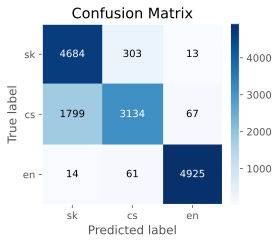

In [52]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

Now you can see, there is lesser misclassification in Czech language. With less number of features (en and sk have 75 unique words while czech had only 59), if you train youur model in a clever way, you can achieve a better performance

In [54]:
f1_score(y_val, predictions, average='weighted')

0.8456381060126386

You can try this model on a different data. 